<a href="https://www.kaggle.com/code/kavishchaudhary1003/playground-s3-e12-optuna-xgb-lgbm-catboost?scriptVersionId=128546490" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedKFold, KFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import optuna


import os
for dirname, _, filenames in os.walk('/kaggle/input/playground-series-s3e12'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e12/sample_submission.csv
/kaggle/input/playground-series-s3e12/train.csv
/kaggle/input/playground-series-s3e12/test.csv


# Competition page
https://www.kaggle.com/competitions/playground-series-s3e12

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e12/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e12/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')

### Drop id from train and test set

In [3]:
train.drop(columns = ['id'], inplace = True)
test.drop(columns = ['id'], inplace = True)

### Checking for null and duplicates

In [4]:
train.isna().sum()
train.duplicated().sum()

0

In [5]:
for i in train.columns:
    print(train[i].value_counts())

1.021    51
1.017    49
1.020    31
1.025    30
1.008    29
1.011    28
1.024    24
1.015    21
1.010    20
1.018    14
1.014    13
1.019    10
1.023    10
1.026    10
1.022     9
1.013     9
1.012     9
1.007     9
1.009     8
1.034     6
1.028     6
1.033     4
1.031     4
1.005     3
1.040     3
1.006     2
1.029     1
1.027     1
Name: gravity, dtype: int64
5.53    34
5.68    16
6.13    13
5.58    13
6.19    12
        ..
6.90     1
5.90     1
5.96     1
7.30     1
5.63     1
Name: ph, Length: 71, dtype: int64
577    23
874    23
781    12
840    11
364    10
       ..
251     1
873     1
312     1
933     1
749     1
Name: osmo, Length: 80, dtype: int64
29.0    43
23.6    28
27.6    19
21.4    19
11.2    16
        ..
27.5     1
17.6     1
21.8     1
15.6     1
12.4     1
Name: cond, Length: 65, dtype: int64
159    16
87     14
385    13
395    13
75     11
       ..
10      1
14      1
184     1
130     1
161     1
Name: urea, Length: 73, dtype: int64
4.49    23
1.16    17
1.27  

### Summary stats

In [ ]:
train.describe()

### Co relation heat map


In [6]:
corr= train.corr()
corr.style.background_gradient(cmap= 'coolwarm')

,gravity,ph,osmo,cond,urea,calc,target
gravity,1.000000,-0.290349,0.692317,0.470433,0.631710,0.494304,0.282577
ph,-0.290349,1.000000,-0.309495,-0.190185,-0.279749,-0.214402,-0.094983
osmo,0.692317,-0.309495,1.000000,0.708480,0.809880,0.472114,0.244770
cond,0.470433,-0.190185,0.708480,1.000000,0.499109,0.330609,0.172224
urea,0.631710,-0.279749,0.809880,0.499109,1.000000,0.489879,0.265211
calc,0.494304,-0.214402,0.472114,0.330609,0.489879,1.000000,0.467439
target,0.282577,-0.094983,0.244770,0.172224,0.265211,0.467439,1.000000


### Plotting the  continuous predictor variables

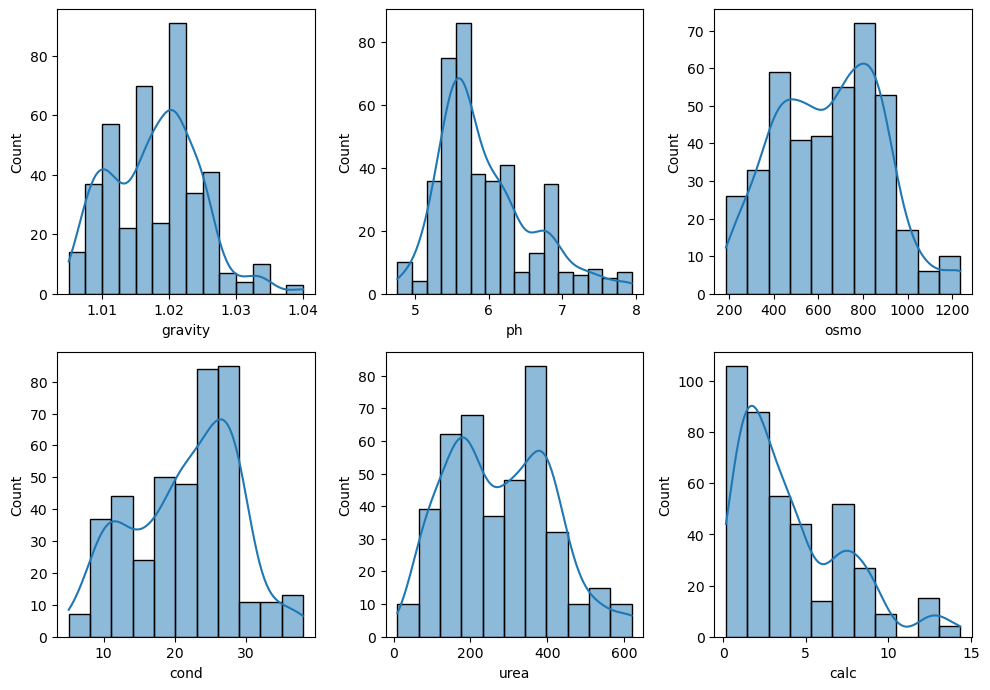

In [7]:
plt.figure(figsize = (10,10))
for i in range(len(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'])):
    plt.subplot(3,3, i+1)
    sns.histplot(x = train[(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'])[i]], kde = True)
    plt.tight_layout()

### Plotting the  boxplot of continuous predictor variables

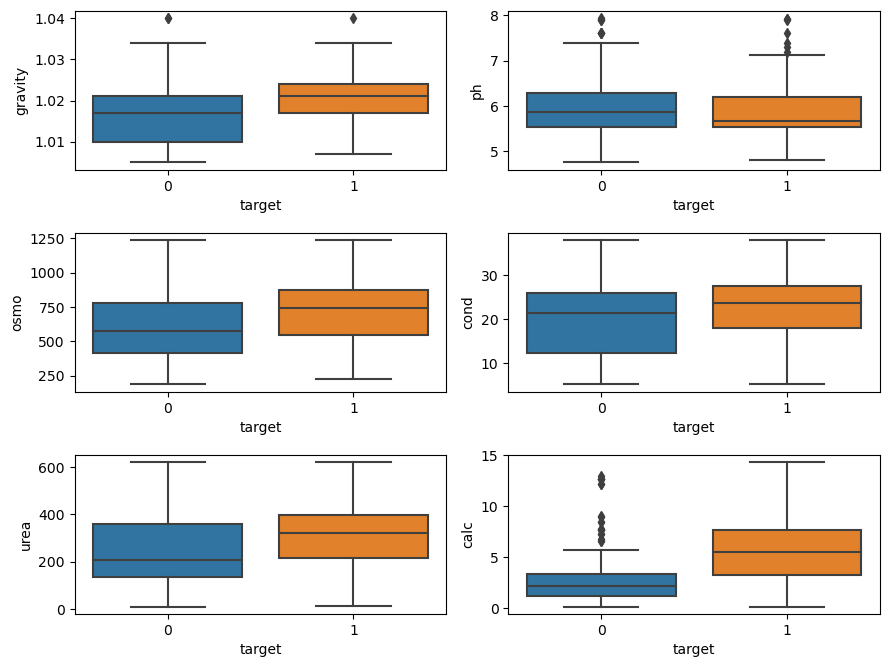

In [8]:
plt.figure(figsize = (9,13))
for i in range(len(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'])):
    plt.subplot(6,2,i+1)
    sns.boxplot(y = train[(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'])[i]], x = train.target)
    plt.tight_layout()

### Plotting the target variable

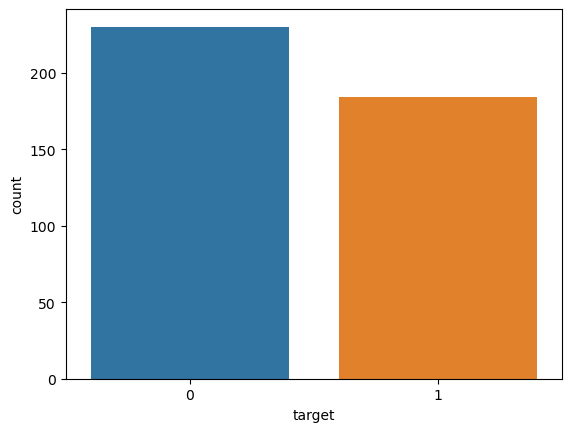

In [9]:
sns.countplot(x = train.target)
plt.show()

### Separating features and target variable

In [10]:
y= train.target
train.drop(columns = ['target'], inplace = True)

### Optuna parameter tuning- XG Boost

In [ ]:
def obj_xg(trial):
    params={
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate',0.1,1),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'gamma': trial.suggest_float('gamma', 1e-5, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample',0,1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    scores = []
    optuna_model = XGBClassifier(**params, objective = 'binary:logistic')
    cv= RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 100)
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy= optuna_model.predict_proba(testx)[:,1]
        scores.append(roc_auc_score(testy, predy))
    return np.mean(scores)
study_xg = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_xg.optimize(obj_xg, n_trials = 1)
        pbar.update(1)

### Optuna parameter tuning- Light GBM

In [ ]:
def obj_light(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.1,1),
        'n_estimators': trial.suggest_int('n_estimators', 200,1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1,1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0,1)
    }
    scores = []
    optuna_model = LGBMClassifier(**params)
    cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 100)
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx,trainy)
        predy = optuna_model.predict_proba(testx)[:,1]
        scores.append(roc_auc_score(testy, predy))
    return np.mean(scores)
study_light = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_light.optimize(obj_light, n_trials = 1)
        pbar.update(1)

### Optuna parameter tuning- Cat Boost

In [ ]:
def obj_cat(trial):
    params={
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0,1),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.01,0.1),
        'depth': trial.suggest_int('depth', 1, 10)
    }
    optuna_model = CatBoostClassifier(**params, verbose = False)
    cv = RepeatedKFold(n_splits = 10, n_repeats = 10, random_state = 100)
    scores = []
    for train_index, test_index in cv.split(train, y):
        trainx, testx = train.iloc[train_index], train.iloc[test_index]
        trainy, testy = y[train_index], y[test_index]
        optuna_model.fit(trainx, trainy)
        predy = optuna_model.predict_proba(testx)[:,1]
        scores.append(roc_auc_score(testy, predy))
    return np.mean(scores)
study_cat = optuna.create_study(direction = 'minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
n_trials = 50
with tqdm(total = n_trials) as pbar:
    for i in range(n_trials):
        study_cat.optimize(obj_cat, n_trials = 1)
        pbar.update(1)

### Predicting the values for the test set

In [ ]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 0)
pred_xgb = np.zeros(test.shape[0])
pred_cat = np.zeros(test.shape[0])
pred_lgb = np.zeros(test.shape[0])
auc_xgb=[]  
auc_cat=[]
auc_lgb=[]
n = 0

for train_index, test_index in cv.split(train, y):
    trainx, testx = train.iloc[train_index], train.iloc[test_index]
    trainy, testy = y[train_index], y[test_index] 
    
    # XGBoost classifier
    model_xgb = XGBClassifier(early_stopping_rounds=100, **study_xg.best_params)
    model_xgb.fit(trainx,trainy,eval_set=[(testx, testy)],verbose= False ) 
    pred_xgb+=model_xgb.predict(test)/cv.n_splits
    auc_xgb.append(roc_auc_score(testy, model_xgb.predict_proba(testx)[:,1]))
     
    # CatBoost classifier
    model_cat = CatBoostClassifier(**study_cat.best_params)
    model_cat.fit(trainx,trainy,eval_set=[(testx, testy)],early_stopping_rounds=100,verbose= False ) 
    pred_cat+=model_cat.predict(test)/cv.n_splits
    auc_cat.append(roc_auc_score(testy, model_cat.predict_proba(testx)[:,1]))
    
    
    # LightGBM classifier
    model_lgb = LGBMClassifier(**study_light.best_params)
    model_lgb.fit(trainx,trainy,eval_set=[(testx,testy)],early_stopping_rounds=100,verbose= False ) 
    pred_lgb+=model_lgb.predict(test)/cv.n_splits
    auc_lgb.append(roc_auc_score(testy, model_lgb.predict_proba(testx)[:,1]))
    
    
    print(f"fold: {n+1} auc xgb: {auc_xgb[n]} | auc cat: {auc_cat[n]} | auc LGBM: {auc_lgb[n]} ")
    n+=1


# The best model

In [ ]:
submission = pd.read_csv('/kaggle/input/playground-series-s3e12/sample_submission.csv')
submission['XGB'] = pred_xgb
submission['target'] = submission['XGB']
final_submission = pd.DataFrame(submission, columns=['id', 'target'])
final_submission.to_csv('predictions.csv', index = False)

In [ ]:
submission['CAT'] = pred_cat
submission['target'] = submission['CAT']
final_submission = pd.DataFrame(submission, columns=['id', 'target'])
final_submission.to_csv('predictions.csv', index = False)

In [ ]:
submission['LGBM'] = pred_lgb
submission['target'] = submission['LGBM']
final_submission = pd.DataFrame(submission, columns=['id', 'target'])
final_submission.to_csv('predictions.csv', index = False)